<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/FINANCE/VT_total_return.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# VT Total Return (Adjusted Close)

This Colab notebook downloads publicly available data for the Vanguard Total World Stock ETF (VT) and plots a total return–like series using Yahoo Finance's Adjusted Close (which adjusts for dividends and splits).  
> **Note:** Yahoo's Adjusted Close is commonly used as a proxy for total return with dividend reinvestment, but it may not match official provider total return indices exactly.



## Contents
1. [Environment Setup](#setup)  
2. [Parameters](#params)  
3. [Download Public Data (Yahoo Finance via `yfinance`)](#download)  
4. [Make a Total-Return–Like Index](#tri)  
5. [Plot on a Log Scale](#plot)  
6. [Inspect Dividend Events](#divs)  


## 1. Environment Setup <a id='setup'></a>

In [1]:

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data source
import yfinance as yf

# Make plots a bit larger
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True


## 2. Parameters <a id='params'></a>

In [2]:

# --- User-editable parameters ---
TICKER = "VT"           # Vanguard Total World Stock ETF
START = "2008-01-01"    # start date for the analysis
END = None              # None => up to latest available
BASE_VALUE = 100.0      # starting value for the total-return-like index
FREQ = "B"              # reindex frequency: 'B' = business days

# You can change START, END, or BASE_VALUE to taste.


## 3. Download Public Data (Yahoo Finance via `yfinance`) <a id='download'></a>

In [3]:

#@title Download historical OHLCV and dividends for VT
# 'Adj Close' reflects price adjusted for dividends and splits (proxy for total return).
ticker = yf.Ticker(TICKER)

# Price history (includes 'Adj Close')
hist = ticker.history(start=START, end=END, auto_adjust=False)

if hist.empty:
    raise ValueError(f"No data returned for {TICKER}. Try a different date range or check the ticker.")

# Keep only the Adjusted Close; drop rows with NA
adj = hist[['Adj Close']].dropna().rename(columns={'Adj Close': 'AdjClose'})

# (Optional) Bring to a regular business-day grid (forward-fill gaps like holidays)
adj = adj.asfreq(FREQ, method='ffill')
adj.head()


,AdjClose
Date,
2008-06-26 00:00:00-04:00,34.349205
2008-06-27 00:00:00-04:00,34.293789
2008-06-30 00:00:00-04:00,34.321499
2008-07-01 00:00:00-04:00,34.016666
2008-07-02 00:00:00-04:00,33.517849


## 4. Make a Total-Return–Like Index <a id='tri'></a>

In [4]:

#@title Create a normalized index where the first available Adjusted Close = BASE_VALUE.
# Because AdjClose accounts for dividends and splits, this behaves like a total return index.
tri = (adj / adj.iloc[0]) * BASE_VALUE
tri.rename(columns={'AdjClose': 'VT_TR_Index'}, inplace=True)

tri.head()


,VT_TR_Index
Date,
2008-06-26 00:00:00-04:00,100.000000
2008-06-27 00:00:00-04:00,99.838668
2008-06-30 00:00:00-04:00,99.919340
2008-07-01 00:00:00-04:00,99.031888
2008-07-02 00:00:00-04:00,97.579693


## 5. Plot on a Log Scale <a id='plot'></a>

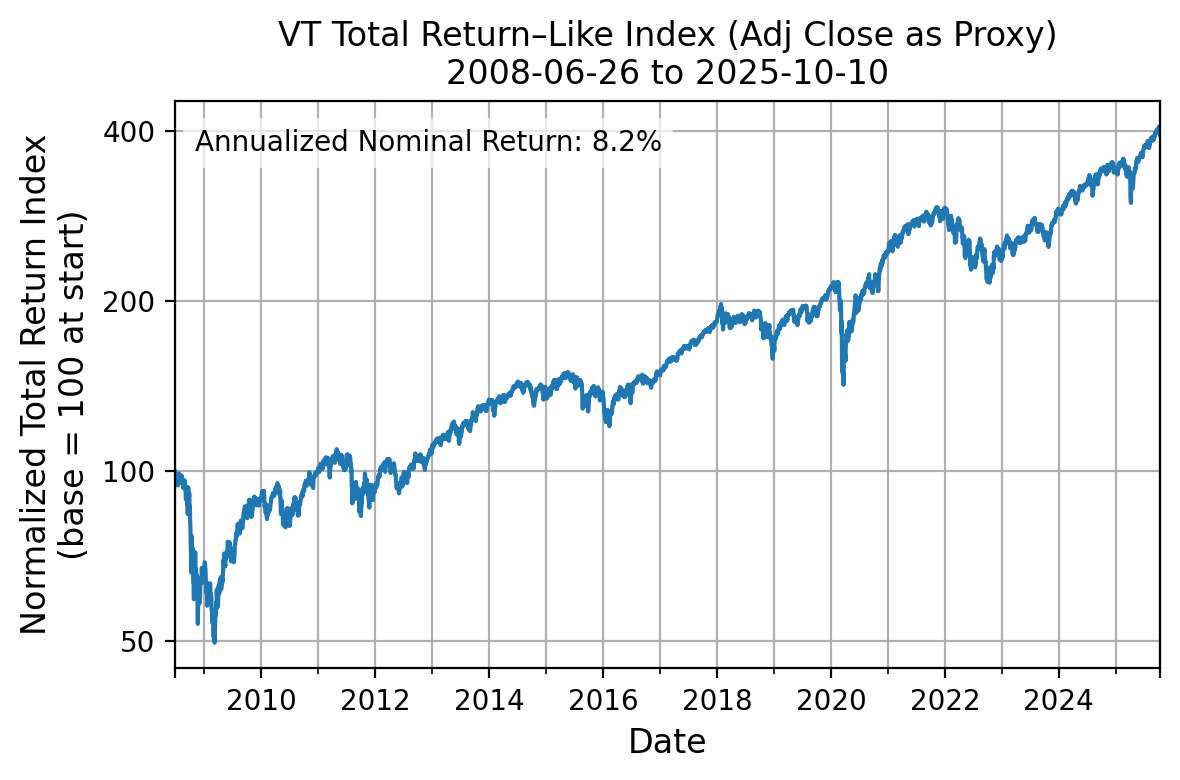

In [5]:
#@title Plot the total-return-like index on a log scale with plain-number ticks (no exponents).
from matplotlib.ticker import FixedLocator, FixedFormatter
import math


# --- Plot style parameters ---
LABEL_FONTSIZE = 12      # axis label & title
TICK_FONTSIZE  = 10      # tick labels
FIG_WIDTH_IN   = 6       # inches
FIG_HEIGHT_IN  = 4       # inches
FIG_DPI        = 200     # resolution

# Tick anchor for power-of-two ticks on log scale
TICK_ANCHOR = 100.0      # ticks at 100 * 2^k (…50, 100, 200, 400… if in range)


# --- helper: build ticks at anchor * 2^k inside data range ---
def pow2_ticks(ymin, ymax, anchor=100.0):
    if ymin <= 0:
        raise ValueError("ymin must be > 0 for log scale.")
    k_min = math.floor(math.log(ymin / anchor, 2))
    k_max = math.ceil(math.log(ymax / anchor, 2))
    ticks = [anchor * (2 ** k) for k in range(k_min, k_max + 1)]
    return [t for t in ticks if ymin*0.98 <= t <= ymax*1.02]

# Figure
fig, ax = plt.subplots(figsize=(FIG_WIDTH_IN, FIG_HEIGHT_IN), dpi=FIG_DPI)
tri['VT_TR_Index'].plot(ax=ax, legend=False)

# Log scale
ax.set_yscale('log')

# Compute desired ticks (100 × powers of 2 within the data range)
ymin, ymax = tri['VT_TR_Index'].min(), tri['VT_TR_Index'].max()
ticks = pow2_ticks(ymin, ymax, anchor=TICK_ANCHOR if 'TICK_ANCHOR' in globals() else 100.0)

# Apply fixed ticks and *string* labels (prevents scientific notation/mathtext)
ax.yaxis.set_major_locator(FixedLocator(ticks))
ax.yaxis.set_major_formatter(FixedFormatter([f"{int(round(t)):,}" for t in ticks]))

# Optional: turn off minor tick labels to avoid clutter
ax.yaxis.set_minor_locator(FixedLocator([]))

# Labels, title, fonts
ax.set_title(f"{TICKER} Total Return–Like Index (Adj Close as Proxy)\n"
             f"{tri.index.min().date()} to {tri.index.max().date()}",
             fontsize=LABEL_FONTSIZE)
ax.set_xlabel("Date", fontsize=LABEL_FONTSIZE)
ax.set_ylabel("Normalized Total Return Index\n(base = 100 at start)", fontsize=LABEL_FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)

ax.grid(True, which='both', axis='both')
plt.tight_layout()

# --- Annualized nominal return (% p.a.) ---
n_years = (tri.index[-1] - tri.index[0]).days / 365.25
cagr = (tri['VT_TR_Index'].iloc[-1] / tri['VT_TR_Index'].iloc[0])**(1/n_years) - 1

# Add annotation inside the plot (top-left corner)
ax.text(
    0.02, 0.95,
    f"Annualized Nominal Return: {cagr*100:.1f}%",
    transform=ax.transAxes,
    ha='left', va='top',
    fontsize=TICK_FONTSIZE,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.show()


## 6. Inspect Dividend Events <a id='divs'></a>

In [6]:

#@title Pull dividend events to confirm that cash dividends exist in the period.
# Note: Adjusted Close already accounts for these for the proxy TR series.
divs = ticker.dividends
if not divs.empty:
    display(divs.loc[str(pd.to_datetime(START).year):])
else:
    print("No dividend data available from Yahoo for this period.")


,Dividends
Date,
2008-12-24 00:00:00-05:00,0.203
2009-12-24 00:00:00-05:00,0.662
2010-12-22 00:00:00-05:00,0.918
2011-12-21 00:00:00-05:00,1.018
2012-09-24 00:00:00-04:00,0.584
2012-12-20 00:00:00-05:00,0.555
2013-03-22 00:00:00-04:00,0.164
2013-06-24 00:00:00-04:00,0.439
2013-09-23 00:00:00-04:00,0.245



---

### Notes & Caveats
Adjusted Close from Yahoo Finance is often used as a proxy for total return with reinvested dividends. It may not perfectly match official provider total return indices.


